# Model Selection
We used three types of models which are Custom LSTM, Bidirectional LSTM and RNN, inorder to compare them

In [64]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

my_scaler = MinMaxScaler().fit(train_df)
my_scaler_tv = MinMaxScaler().fit(train_df[['traffic_volume']])
scaled_train_df = pd.DataFrame(my_scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
scaled_val_df = pd.DataFrame(my_scaler.transform(val_df), index=val_df.index, columns=val_df.columns)
scaled_test_df = pd.DataFrame(my_scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

# Let's test the normalizing and denormalizing scheme
traffic_volume_original = train_df.traffic_volume[0]
traffic_volume_scaled = scaled_train_df.traffic_volume[0]
traffic_volume_denormalized = float(my_scaler_tv.inverse_transform(scaled_train_df[['traffic_volume']])[0])

print("Original Traffic Volume:", traffic_volume_original)
print("Scaled Traffic Volume:", traffic_volume_scaled)
print("Denormalized Traffic Volume:", traffic_volume_denormalized)

Original Traffic Volume: 5545.0
Scaled Traffic Volume: 0.7616758241758241
Denormalized Traffic Volume: 5545.0


In [65]:
# Single value denormalization
#np.float(my_scaler_tv.inverse_transform(np.array([[.7]])))

import numpy as np

# Assuming you have defined the `my_scaler_tv` object and imported necessary modules

# Single value denormalization
denormalized_value = float(my_scaler_tv.inverse_transform(np.array([[0.7]])))
print(denormalized_value)

5096.0


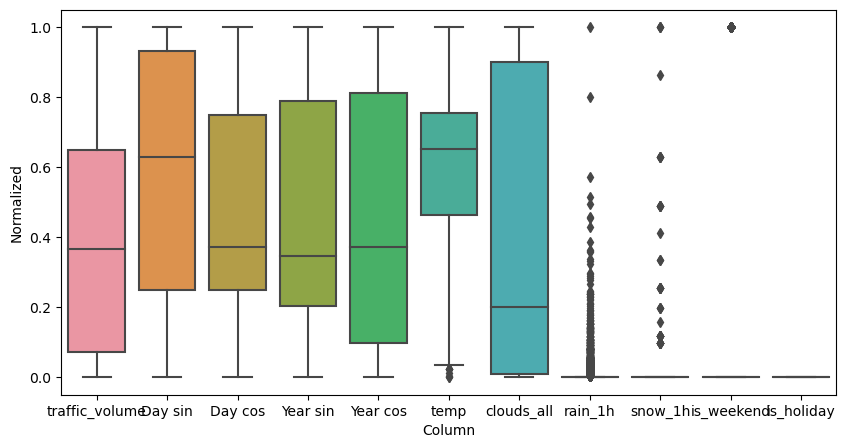

In [66]:
df_scaled = scaled_train_df.iloc[:,:11].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='Column', y='Normalized', data=df_scaled)


The data is showing rain and snow having alot of outliers. I'm unaware if this is corrupt data or if that's the actual weather in that area.

In [67]:
# Utility functions
# Special Characters for Output Formating
StartBold = "\033[1m"
EndBold = "\033[0m"

#### WindowGenerator   
I modified the WindowGenerator class to have all the required methods and properties consolidated from the beginging in contrast to the original design of adding the methods and properties at subsequent steps.

# Model Architecture Design

In [68]:
'''
The WindowGenerator class.
Start by creating the `WindowGenerator` class. The `__init__` method includes
all the necessary logic for the input and label indices.
It also takes the train, eval, and test dataframes as input.
These will be converted to `tf.data.Dataset`s of windows later.

This class can:

1 - Handle the indexes and offsets as shown in the diagrams above.
2 - Split windows of features into a (features, labels) pairs.
3 - Plot the content of the resulting windows.
4 - Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.
'''
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, batch_size=32,
                 train_df=scaled_train_df, val_df=scaled_val_df, test_df=scaled_test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.example = None

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                           enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.batch_size = batch_size

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size} = {self.input_width}+({self.shift-self.label_width}+{self.label_width})',
            f'Batch size: {self.batch_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices} start: [{self.label_start}]',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        '''
        Given a list consecutive inputs, the split_window method will convert
        them to a window of inputs and a window of labels.
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        '''
        The plot method that allows a simple visualization of the split window
        '''
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        # Maskar: Added this line show that we are only showing n slices
        plt.suptitle(f'Showing only {max_n} slices')

    def make_dataset(self, data):
        '''
        Make_dataset method will take a time series DataFrame and convert it to
        a tf.data.Dataset of (input_window, label_window) pairs using the
        preprocessing.timeseries_dataset_from_array function.
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,  # Maskar: I changed this to False
            batch_size=self.batch_size,  # 32,
        )

        ds = ds.map(self.split_window)

        return ds

    # The WindowGenerator object holds training, validation and test data.
    # Add properties for accessing them as tf.data.Datasets using the above make_dataset method.
    # Also add a standard example batch for easy access and plotting:
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    @example.setter
    def example(self, var):
        self._example = var


### plotting

In [69]:
def plot_train_validation(history, validation_data, metric='mean_absolute_error'):
    '''
    Function to plot the training and validation accuracy progress with epochs for a single model
    '''
    plt.plot(history.history[metric], label='train')  # For TF2
    plt.plot(history.history['val_'+metric], label='valid.')  # For TF2
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xticks(range(1,len(history.history['loss'])+1,2))
    #plt.ylim([0.5, 1])
    plt.title(f'{len(history.history[metric])} epochs')
    plt.grid(color='lightgrey', linestyle=':', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.show()

    # Evaluate the learned model with validation set
    print(f'\n\n{StartBold}Validation Scores:{EndBold}\n')
    _ = history.model.evaluate(validation_data, verbose=2)


In [70]:
class TrainingPlot(Callback):
    '''
      A keras callback helper function to plot
      the training/validation plot after each epoch
    '''
    def __init__(self, loss_metric='mean_absolute_error'):
        super().__init__()
        self.loss_metric = loss_metric

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses, and metrics
        self.losses = []
        self.val_losses = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get(self.loss_metric)
        val_loss = logs.get('val_'+self.loss_metric)

        # Append the logs, losses, and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(loss)
        self.val_losses.append(val_loss)

        # Plots every n-th epoch
        if epoch > 0 and epoch % 1 == 0:
            # Clear the previous plot
            IPython.display.clear_output(wait=True)
            N = np.arange(0, len(self.losses))

            # You can choose the style of your preference
            # plt.style.use("seaborn")
            # plt.figure(figsize=(10,3))
            plt.xlabel('Epoch')
            plt.ylabel(self.loss_metric)
            plt.plot(N, self.losses, label='train')
            plt.plot(N, self.val_losses, label='valid.')
            plt.grid(color='lightgrey', linestyle=':', linewidth=0.5)
            val_denorm = float(my_scaler_tv.inverse_transform(np.array([[val_loss]])))
            plt.title(f'Last validation value = {val_denorm:.2f}')
            plt.legend(loc='upper right')
            plt.show()

### Compile and fit

In [76]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler

def compile_and_fit(model, window, patience=5, max_epochs=30, model_label='model', log_dict=None):
    plot_metrics = TrainingPlot()

    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_delta=0.001, patience=patience, mode='min', verbose=1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)

    model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=max_epochs, validation_data=window.val, callbacks=[plot_metrics, early_stopping, rlr])
  
    if log_dict:
        log_dict['our_models'][model_label] = model

        IPython.display.clear_output()

        print(f'\n\n{StartBold}Training vs. Validation:{EndBold}\n')
        plot_train_validation(history, window.val)

        log_dict['multi_val_performance'][model_label] = model.evaluate(window.val, verbose=0)
        log_dict['multi_performance'][model_label] = model.evaluate(window.train, verbose=0)

    return history
